# DMD notes

2019_01_14 (V1): IBS

These notes are here to help seed discussion about DMD's and potential sources of aberation.

In [11]:
import matplotlib.pyplot as pyplot
import matplotlib.gridspec as gridspec

import numpy as np

In all of the below I will refer to the figure

![title](Schematic.png)

In this figure the symbol $f(x-jd)$ describes optical electric field pattern that the $j$-th mirror alone would produce, and $g_j\in \{0,1\}$ defines if the mirror is in the on or off state.  Because the mirror is at an angle, this is not quite a simple window function, but approximatally it is
$$
f(x) \approx \begin{cases}
    1,& \text{for } x\in(-d/2,d/2] \\
    0,              & \text{otherwise}
\end{cases}.
$$

To get a basic idea of what to expect, lets consider the far-field pattern for two cases: (1) With just the $j$-th mirror on and the others off; (2) All the mirrors on $g_j = 1$.  

The far field pattern approximates the Fourier transform of the field, so for case (1) we find,
$$
\tilde E_j(k) = E_0 \tilde f(k) \exp[i (k +  k_0 \sin 2\theta) j d].
$$
This contains the mode-shape of a single mirror, with a phase term associated with the displacement of the mirror, and a second phase term from the DMD.  I guess that this looks simple enough, but when we insert the sum over $j$ (which we take to be an infinite sum), we get 
$$
\tilde E_{\rm on}(k) = E_0 \tilde f(k) \sum_j \exp[i (k +  k_0 \sin 2\theta) j d].
$$
The sum evaluates to
$$
\sum_j \exp[i (k +  k_0 \sin 2\theta) j d] = \sum_n \delta(k d - dk_0 \sin 2\theta - 2 \pi n),
$$
i.e., an array of Dirac delta functions spaced by $\delta k = 2 \pi / d$, and shifted by $\kappa = dk_0 \sin 2\theta$.  

This is the diffraction pattern from the DMD mirror array centered at $k=dk_0 \sin 2\theta$, shaped by the mode field function of a single mirror centered at $k=0$.  This then provides the origin of potential aborations since the indivual mirror distribution is symmetric about $k=0$ while the information about the mirror distribution is centered on a place in $\tilde f(\kappa)$ that contains a gradient.

## Lets see what this all means!

I will compose some python scripts the model different values of $\kappa$ for a very simple step function pattern

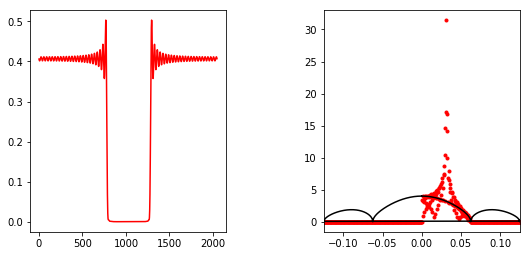

In [171]:
# Total size of grid
pts = 2048

# Single mirror size (must divide grid size)
pts_mirror = 16
assert pts % pts_mirror == 0

# Number of mirrors (must be even)
num_mirrors = pts // pts_mirror
assert num_mirrors % 2 == 0

# kappa parameter (zero to 1.0 in these units)
kappa = 0.5

# construct simple pattern of mirrors
jvals = np.arange(-num_mirrors//2, num_mirrors//2)
g_0 = np.where(np.abs(jvals) < num_mirrors / 8, 0.0, 1.0)
# g_0 = np.where(np.abs(jvals) == 0, 1.0, 0.0)
# g_0.fill(1.0)
g_0.astype(complex)

# convert this to the pattern of fields
xvals = np.arange(0, pts)
mirror_map = xvals // pts_mirror
phase_map = np.exp(2.0j*np.pi*mirror_map*kappa)
f_0 = phase_map * g_0[mirror_map]
f_single = np.where(mirror_map == 0, 1.0, 0.0)

#
# Compute the Fourier transform and mask
#

kvals= np.fft.fftfreq(f_0.shape[0])

f_0_FT = np.fft.fftn(f_0)
f_0_PSD = np.abs(f_0_FT)**2

f_single_FT = np.fft.fftn(f_single)
f_single_PSD = np.abs(f_single_FT)**2

# Aperture
mask = np.where(np.abs(kvals*pts_mirror - kappa) < 0.5, 1.0, 0.0)

f_0_FT_mask = f_0_FT*mask
f_0_mask_PSD = np.abs(f_0_FT_mask)**2

# Roll the data so it is "centered"
# f_0_FT_mask = np.roll(f_0_FT_mask, -int(kappa*pts / pts_mirror) )
# f_0_mask_PSD = np.roll(f_0_mask_PSD, -int(kappa*pts / pts_mirror) )

f_0_mask = np.fft.ifftn(f_0_FT_mask)

#
# Display data
#

fig = pyplot.figure(1,figsize=(8,4))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.1, right=0.95, top=0.92, bottom=0.15, 
          hspace=0.7, wspace=0.5)

ax = fig.add_subplot(gs[0,0])
# ax.plot(xvals, np.abs(f_0)**2, color='k'  )
ax.plot(xvals, np.abs(f_0_mask)**2, color='r'  )
# ax.set_xlim(1000, 1060)

ax = fig.add_subplot(gs[0,1])
ax.plot(kvals, f_0_mask_PSD**0.25, ".", color='r')
ax.plot(kvals, f_single_PSD**0.25, "-", color='k')
ax.set_xlim(-2/pts_mirror, 2/pts_mirror)

pass